## Import

In [1]:
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
from shapely.geometry import box
import pandas as pd
from collections import defaultdict

## GeoPKG to GeoJSON

In [2]:
# Load the GeoPackage file (adjust layer name if needed)
gpkg_path = "data/raw/carte 1928 christelle.gpkg"

gdf = gpd.read_file(gpkg_path)

# Save to GeoJSON
geojson_path = "data/raw_geojson/roads_1_1928.geojson"
gdf.to_file(geojson_path, driver="GeoJSON")

print(f"GeoJSON file saved at: {geojson_path}")

GeoJSON file saved at: data/raw_geojson/roads_1_1928.geojson


## Map Visualisation

In [12]:
roads_2025_path = "data/processed/roads_2025.geojson"
roads_2025_gdf = gpd.read_file(roads_2025_path)

roads_1975_path = "data/processed/roads_1975.geojson"
roads_1975_gdf = gpd.read_file(roads_1975_path)

roads_1928_path = "data/processed/roads_1928.geojson"
roads_1928_gdf = gpd.read_file(roads_1928_path)

roads_1875_path = "data/processed/roads_1875.geojson"
roads_1875_gdf = gpd.read_file(roads_1875_path)

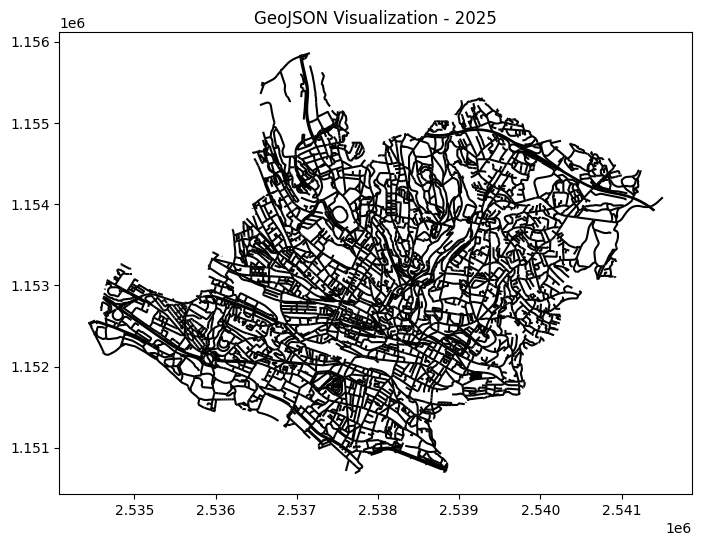

In [4]:
# Plot the GeoJSON file
roads_2025_gdf.plot(figsize=(10, 6), edgecolor="black", cmap="viridis")
plt.title("GeoJSON Visualization - 2025")
plt.show()

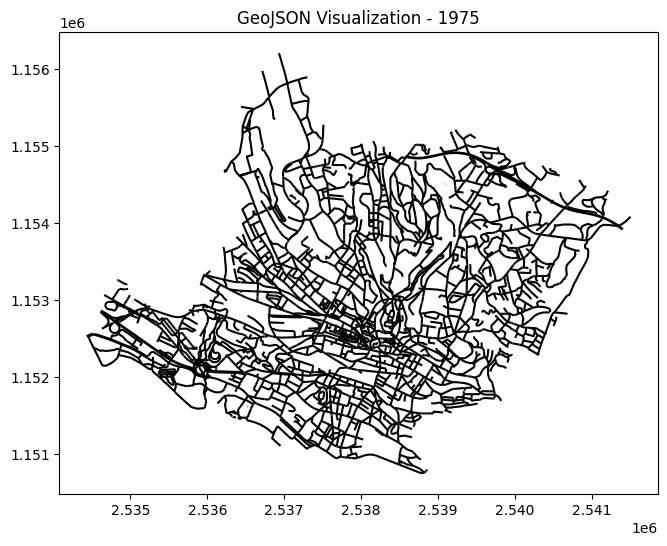

In [5]:
# Plot the GeoJSON file
roads_1975_gdf.plot(figsize=(10, 6), edgecolor="black", cmap="viridis")
plt.title("GeoJSON Visualization - 1975")
plt.show()

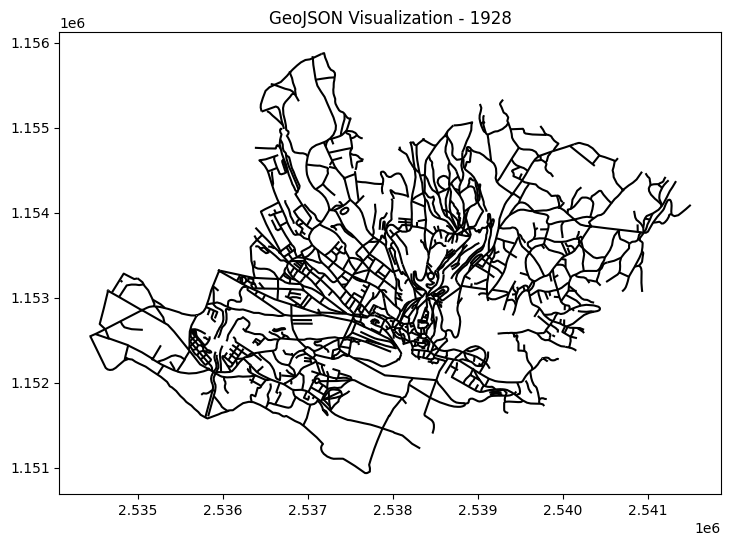

In [6]:
# Plot the GeoJSON file
roads_1928_gdf.plot(figsize=(10, 6), edgecolor="black", cmap="viridis")
plt.title("GeoJSON Visualization - 1928")
plt.show()

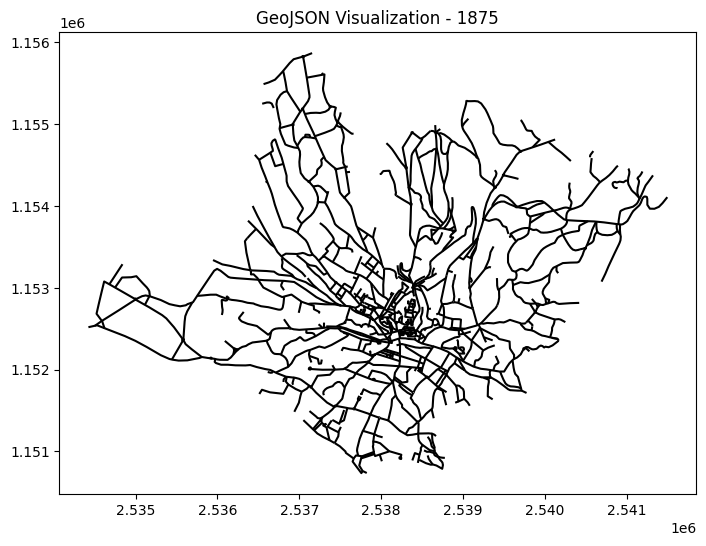

In [7]:
# Plot the GeoJSON file
roads_1875_gdf.plot(figsize=(10, 6), edgecolor="black", cmap="viridis")
plt.title("GeoJSON Visualization - 1875")
plt.show()

## Functions and first example

In [2]:
MEAN_WIDTH = 3.418189974206572
MAX_WIDTH = 8

# Load GeoJSON with roads
def load_roads(geojson_path):
    return gpd.read_file(geojson_path)

# Create a grid of square patches over the bounding box of the roads
def create_grid(gdf, n_patches, bounds):
    minx, miny, maxx, maxy = bounds
    x_grid = np.linspace(minx, maxx, n_patches + 1)
    y_grid = np.linspace(miny, maxy, n_patches + 1)
    
    grid = []
    for i in range(n_patches):
        for j in range(n_patches):
            cell = box(x_grid[i], y_grid[j], x_grid[i+1], y_grid[j+1])
            grid.append(cell)
    
    grid_gdf = gpd.GeoDataFrame(geometry=grid, crs=gdf.crs)
    return grid_gdf

# Compute road density in each patch (total road length / patch area)
def compute_density(grid_gdf, roads_gdf):
    densities_length = []
    # densities_area = []
    
    for idx, patch in enumerate(grid_gdf.geometry):
        roads_in_patch = roads_gdf[roads_gdf.intersects(patch)].copy()
        roads_in_patch = gpd.clip(roads_gdf, patch)
        if len(roads_in_patch) > 0:
            # roads_in_patch["Shape_Width"] = roads_in_patch["OBJEKTART"].apply(lambda x: x[0])

            # roads_in_patch.loc[roads_in_patch.Shape_Width == "A", "Shape_Width"] = str(MAX_WIDTH)
            # roads_in_patch.loc[roads_in_patch.Shape_Width.isin(["P","D"]), "Shape_Width"] = str(MEAN_WIDTH)
            # roads_in_patch.loc[roads_in_patch.Shape_Width == "E", "Shape_Width"] = str(3)

            # roads_in_patch["Shape_Width"] = roads_in_patch["Shape_Width"].astype(float)
            total_road_length = roads_in_patch.length.sum()
            # total_road_area = (roads_in_patch.length * roads_in_patch.Shape_Width).sum()
        
            patch_area = patch.area
            density_length = total_road_length / patch_area if patch_area > 0 else 0
            # density_area = total_road_area / patch_area if patch_area > 0 else 0
        else:
            # density_area = 0
            density_length = 0
        densities_length.append(density_length)
        # densities_area.append(density_area)
    
    grid_gdf["road_density_length"] = densities_length
    # grid_gdf["road_density_area"] = densities_area
    return grid_gdf

# Full pipeline: Compute road density over a grid
def compute_road_density_map(roads_gdf, bounds, n_patches=10):
    grid_gdf = create_grid(roads_gdf, n_patches, bounds)
    density_gdf = compute_density(grid_gdf, roads_gdf)
    
    return density_gdf

# Visualization
def plot_density_map(density_gdf, roads_gdf, year):
    fig, ax = plt.subplots(1,1,figsize=(15, 10))
    density_gdf.plot(column="road_density_length", cmap="OrRd", linewidth=0.5, edgecolor="black", alpha=0.7, legend=False, ax=ax)
    roads_gdf.plot(color="black", linewidth=0.5, alpha=0.5, ax=ax)
    ax.set_title(f"Road Length Density Map {str(year)}")
    ax.set_xlabel("Longitude")
    ax.set_ylabel("Latitude")
    #density_gdf.plot(column="road_density_area", cmap="OrRd", linewidth=0.5, edgecolor="black", alpha=0.7, legend=False, ax=ax[1])
    #roads_gdf.plot(color="black", linewidth=0.5, alpha=0.5, ax=ax[1])
    #ax[1].set_title(f"Road Area Density Map {str(year)}")
    plt.show()

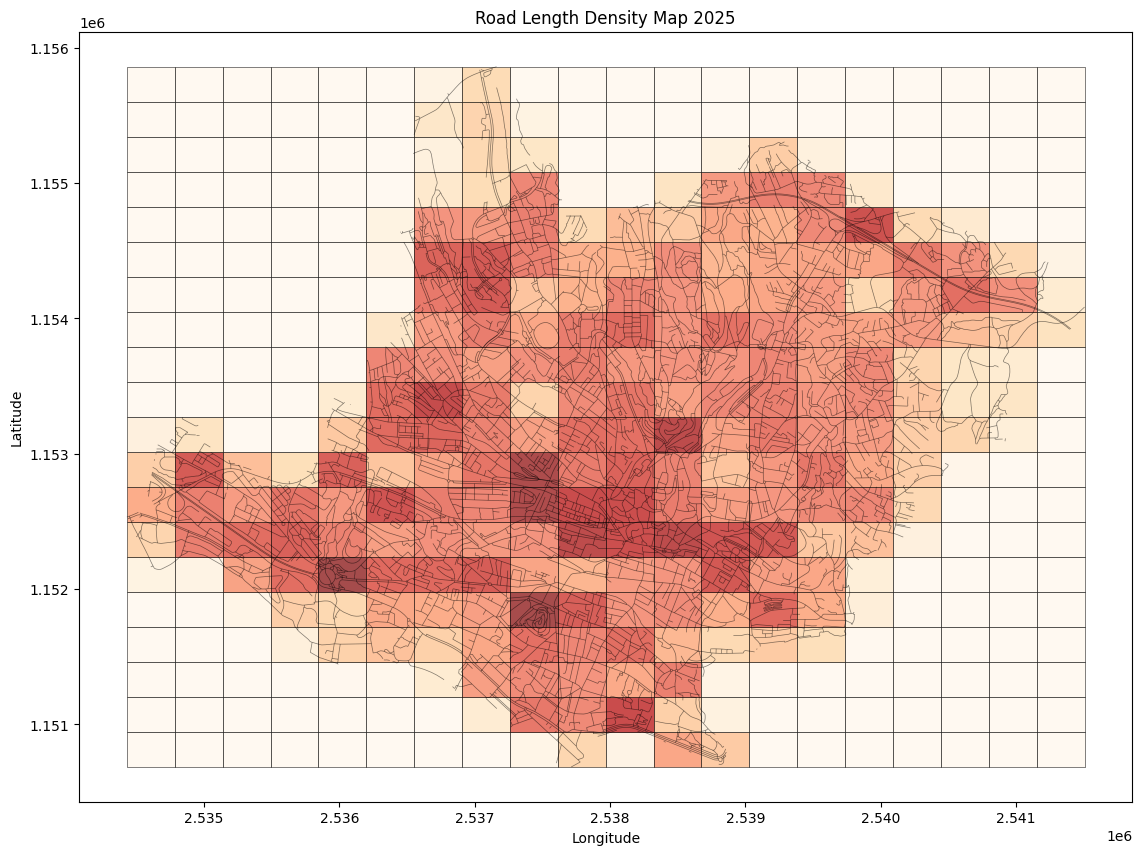

In [16]:
# Example usage
geojson_path = "data/processed/roads_2025.geojson"  # Replace with your file path
n_patches = 20
roads_gdf = load_roads(geojson_path)

# P: Platz -> mean
# A: Autobahn -> max
# E: Einfahrt -> 3
# D: Dienstzufahrt -> mean

density_gdf = compute_road_density_map(roads_gdf, roads_gdf.total_bounds, n_patches)
plot_density_map(density_gdf, roads_gdf, 2025)

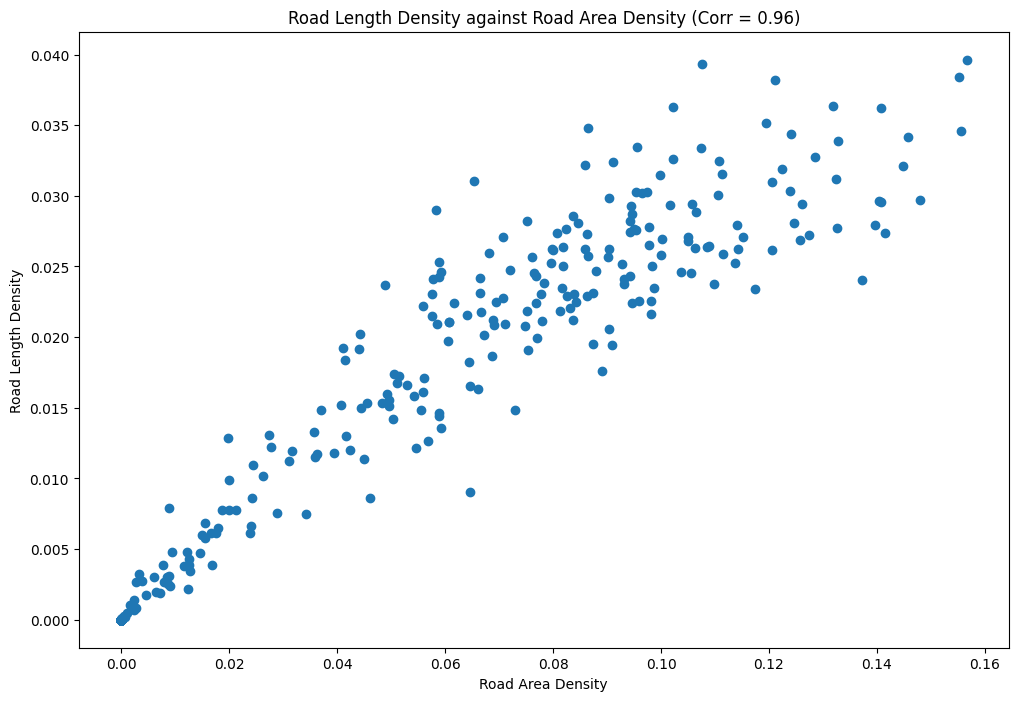

In [17]:
plt.figure(figsize=(12,8))
correlation = density_gdf["road_density_area"].corr(density_gdf["road_density_length"])
plt.scatter(density_gdf.road_density_area, density_gdf.road_density_length)
plt.xlabel("Road Area Density")
plt.ylabel("Road Length Density")
plt.title(f"Road Length Density against Road Area Density (Corr = {round(correlation,2)})")
plt.show()

## 1975 to 2025

In [3]:
roads_2025_path = "data/processed/roads_2025.geojson"
roads_2025_gdf = gpd.read_file(roads_2025_path)

roads_1975_path = "data/processed/roads_1975.geojson"
roads_1975_gdf = gpd.read_file(roads_1975_path)

roads_1928_path = "data/processed/roads_1928.geojson"
roads_1928_gdf = gpd.read_file(roads_1928_path)

roads_1875_path = "data/processed/roads_1875.geojson"
roads_1875_gdf = gpd.read_file(roads_1875_path)

gdfs = [roads_1875_gdf, roads_1928_gdf, roads_1975_gdf,roads_2025_gdf]

In [30]:
N_PATCHES = 40

boundaries = defaultdict(list)

for gdf_year in gdfs:
    minx_year, miny_year, maxx_year, maxy_year = gdf_year.total_bounds
    boundaries["min_x"].append(minx_year)
    boundaries["min_y"].append(miny_year)
    boundaries["max_x"].append(maxx_year)
    boundaries["max_y"].append(maxy_year)

minx = min(boundaries["min_x"])
miny = min(boundaries["min_y"])
maxx = min(boundaries["max_x"])
maxy = min(boundaries["max_y"])

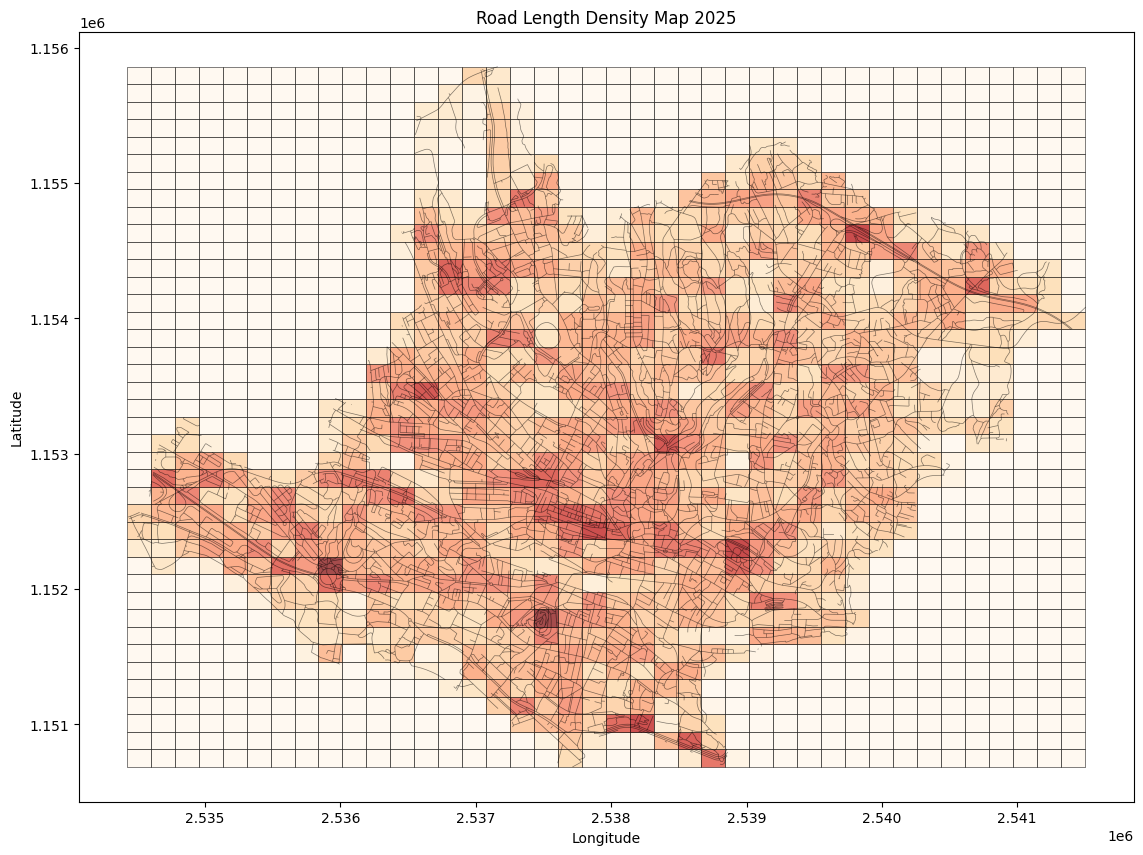

In [31]:
density_2025_gdf = compute_road_density_map(roads_2025_gdf, (minx, miny, maxx, maxy), N_PATCHES)
plot_density_map(density_2025_gdf, roads_2025_gdf, 2025)

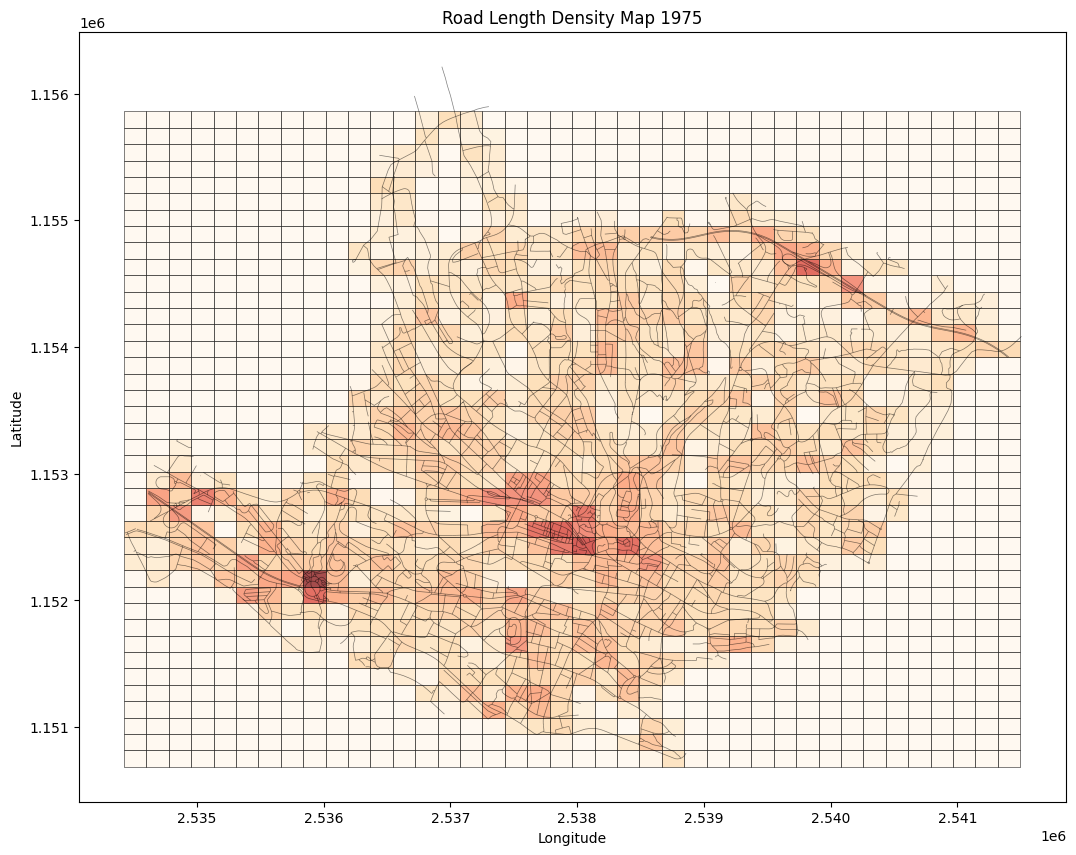

In [32]:
density_1975_gdf = compute_road_density_map(roads_1975_gdf, (minx, miny, maxx, maxy), N_PATCHES)
plot_density_map(density_1975_gdf, roads_1975_gdf, 1975)

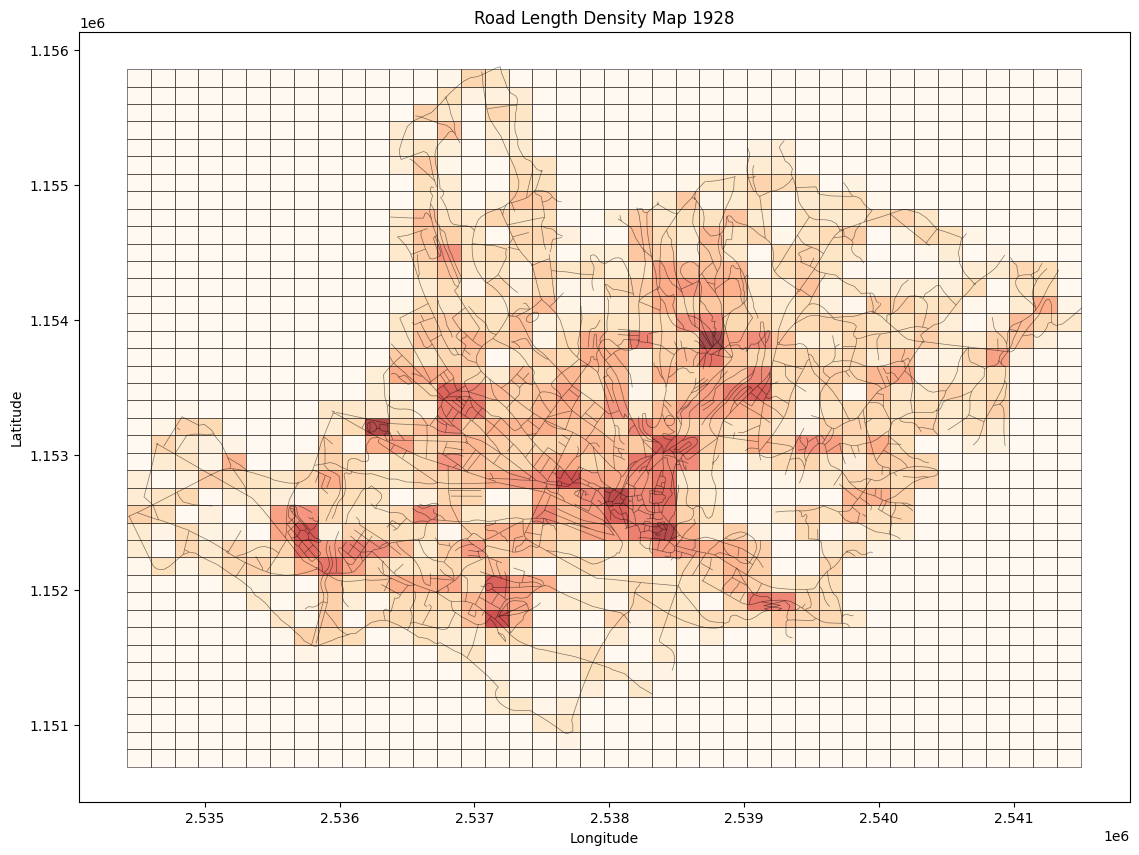

In [33]:
density_1928_gdf = compute_road_density_map(roads_1928_gdf, (minx, miny, maxx, maxy), N_PATCHES)
plot_density_map(density_1928_gdf, roads_1928_gdf, 1928)

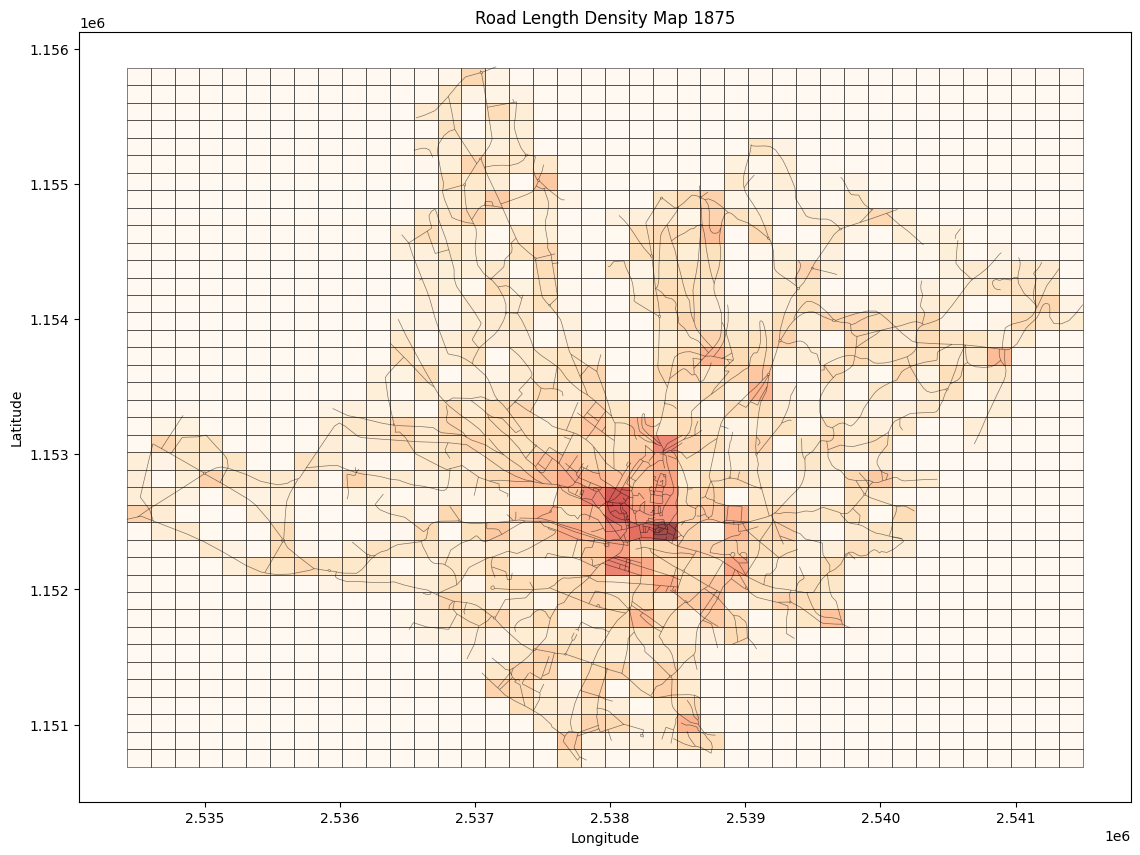

In [34]:
density_1875_gdf = compute_road_density_map(roads_1875_gdf, (minx, miny, maxx, maxy), N_PATCHES)
plot_density_map(density_1875_gdf, roads_1875_gdf, 1875)

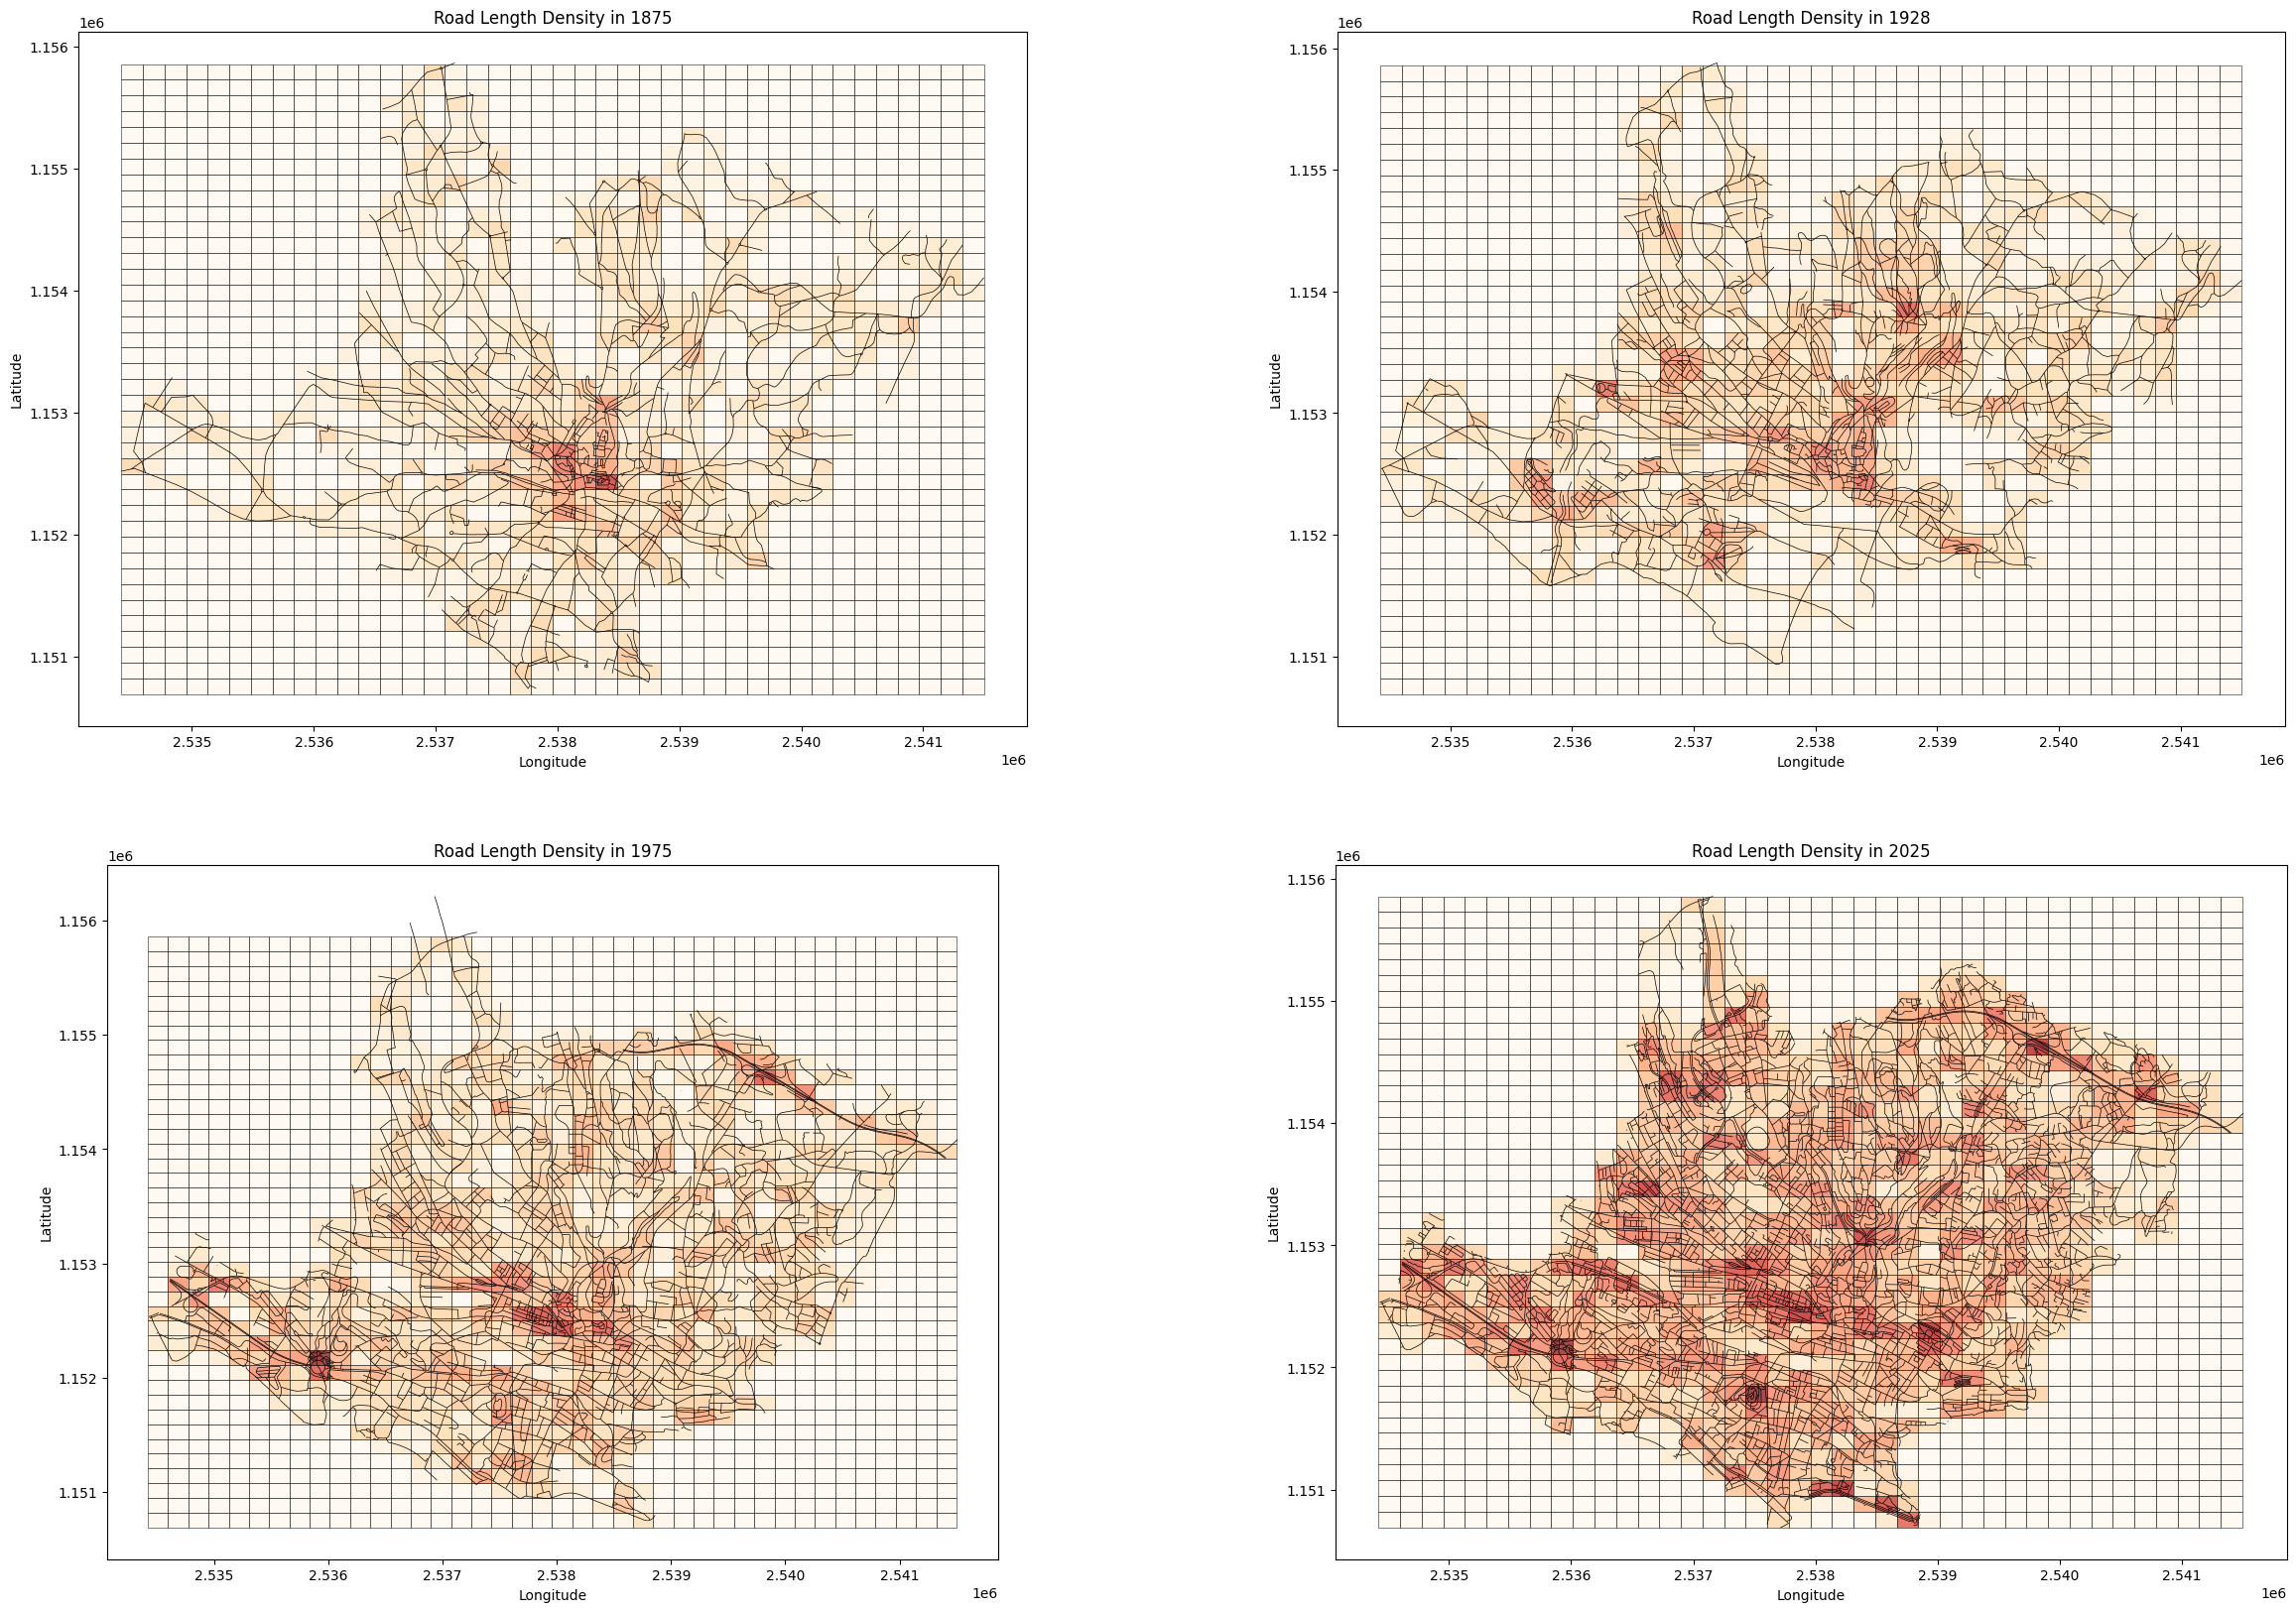

In [35]:
fig, ax = plt.subplots(2,2,figsize=(30, 20))

vmin = 0
vmax = max(density_1875_gdf.road_density_length.max(),density_1928_gdf.road_density_length.max(),density_1975_gdf.road_density_length.max(),density_2025_gdf.road_density_length.max())

density_1875_gdf.plot(column="road_density_length", cmap="OrRd", linewidth=0.5, edgecolor="black", alpha=0.7, legend=False, ax=ax[0][0], vmin=vmin, vmax=vmax)
roads_1875_gdf.plot(color="black", linewidth=0.5, alpha=1, ax=ax[0][0])
ax[0][0].set_title("Road Length Density in 1875")
ax[0][0].set_xlabel("Longitude")
ax[0][0].set_ylabel("Latitude")

density_1928_gdf.plot(column="road_density_length", cmap="OrRd", linewidth=0.5, edgecolor="black", alpha=0.7, legend=False, ax=ax[0][1], vmin=vmin, vmax=vmax)
roads_1928_gdf.plot(color="black", linewidth=0.5, alpha=1, ax=ax[0][1])
ax[0][1].set_title("Road Length Density in 1928")
ax[0][1].set_xlabel("Longitude")
ax[0][1].set_ylabel("Latitude")

density_1975_gdf.plot(column="road_density_length", cmap="OrRd", linewidth=0.5, edgecolor="black", alpha=0.7, legend=False, ax=ax[1][0], vmin=vmin, vmax=vmax)
roads_1975_gdf.plot(color="black", linewidth=0.5, alpha=1, ax=ax[1][0])
ax[1][0].set_title("Road Length Density in 1975")
ax[1][0].set_xlabel("Longitude")
ax[1][0].set_ylabel("Latitude")

density_2025_gdf.plot(column="road_density_length", cmap="OrRd", linewidth=0.5, edgecolor="black", alpha=0.7, legend=False, ax=ax[1][1], vmin=vmin, vmax=vmax)
roads_2025_gdf.plot(color="black", linewidth=0.5, alpha=1, ax=ax[1][1])
ax[1][1].set_title("Road Length Density in 2025")
ax[1][1].set_xlabel("Longitude")
ax[1][1].set_ylabel("Latitude")

plt.show()

In [36]:
densities_gdf = [density_1928_gdf, density_1975_gdf, density_2025_gdf]
years = [1875, 1928, 1975, 2025]

In [37]:
gdf_comparison = density_1875_gdf.copy()
gdf_comparison.rename(columns={"road_density_length":"road_density_length_1875"},inplace=True)

for i in range(len(densities_gdf)):
    prev_year = years[i]
    year = years[i+1]
    gdf = densities_gdf[i].rename(columns={"road_density_length":f"road_density_length_{year}"})
    gdf_comparison = gdf_comparison.merge(gdf, how="inner", on="geometry")
    gdf_comparison[f"{prev_year}_to_{year}"] = gdf_comparison[f"road_density_length_{year}"] - gdf_comparison[f"road_density_length_{prev_year}"]

In [38]:
gdf_comparison['centroid'] = gdf_comparison.geometry.centroid
spatial_index = gdf_comparison.sindex

mean_values = defaultdict(list)

for idx, row in gdf_comparison.iterrows():
    center = row['centroid']
    
    # Define a search box around the centroid (to capture 8 neighbors + self)
    # Assuming your grid has consistent spacing (e.g., 87 meters between centroids based on your polygon)
    buffer_distance = 50  # adjust based on your grid spacing
    bounds = center.buffer(buffer_distance).bounds
    possible_matches_index = list(spatial_index.intersection(bounds))
    possible_matches = gdf_comparison.iloc[possible_matches_index]
    
    # Filter to real neighbors: same-sized patches & touching or nearby centroids
    nearby = possible_matches[possible_matches['centroid'].distance(center) <= buffer_distance * 1.5]
    
    # Compute mean of the 'value' column
    for i in range(len(years)-1):
        mean_val = nearby[f"{years[i]}_to_{years[i+1]}"].mean()
        mean_values[f"{years[i]}_to_{years[i+1]}"].append(mean_val)

# Step 4: Assign the new mean values to a new column
for key in mean_values:
    gdf_comparison[key+'_smoothed_value'] = mean_values[key]

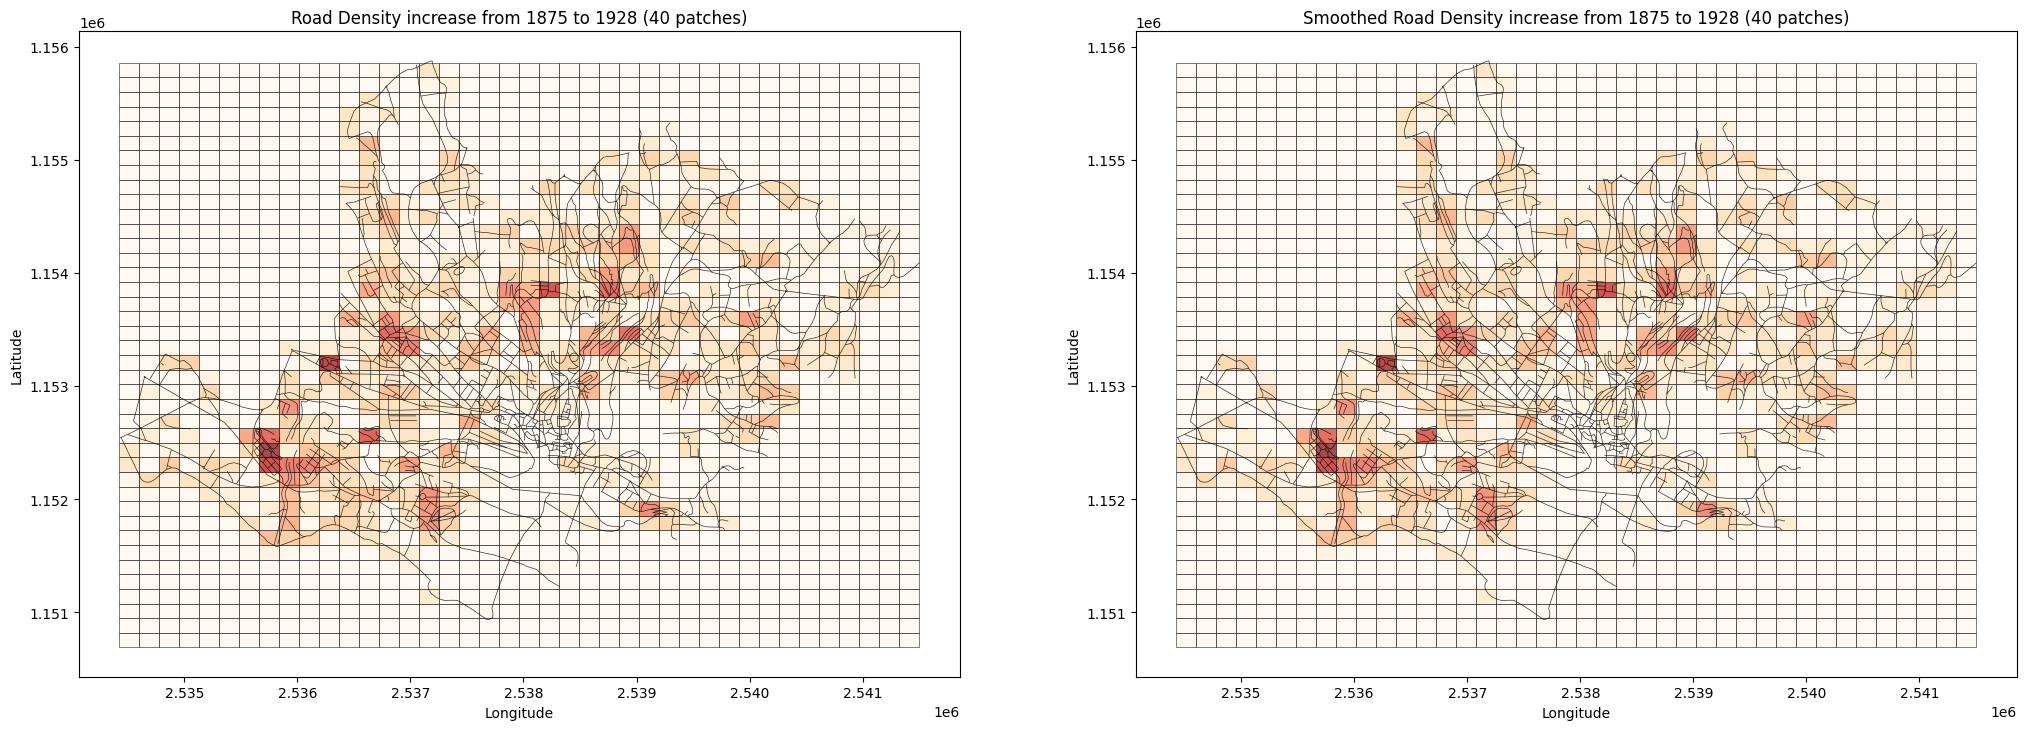

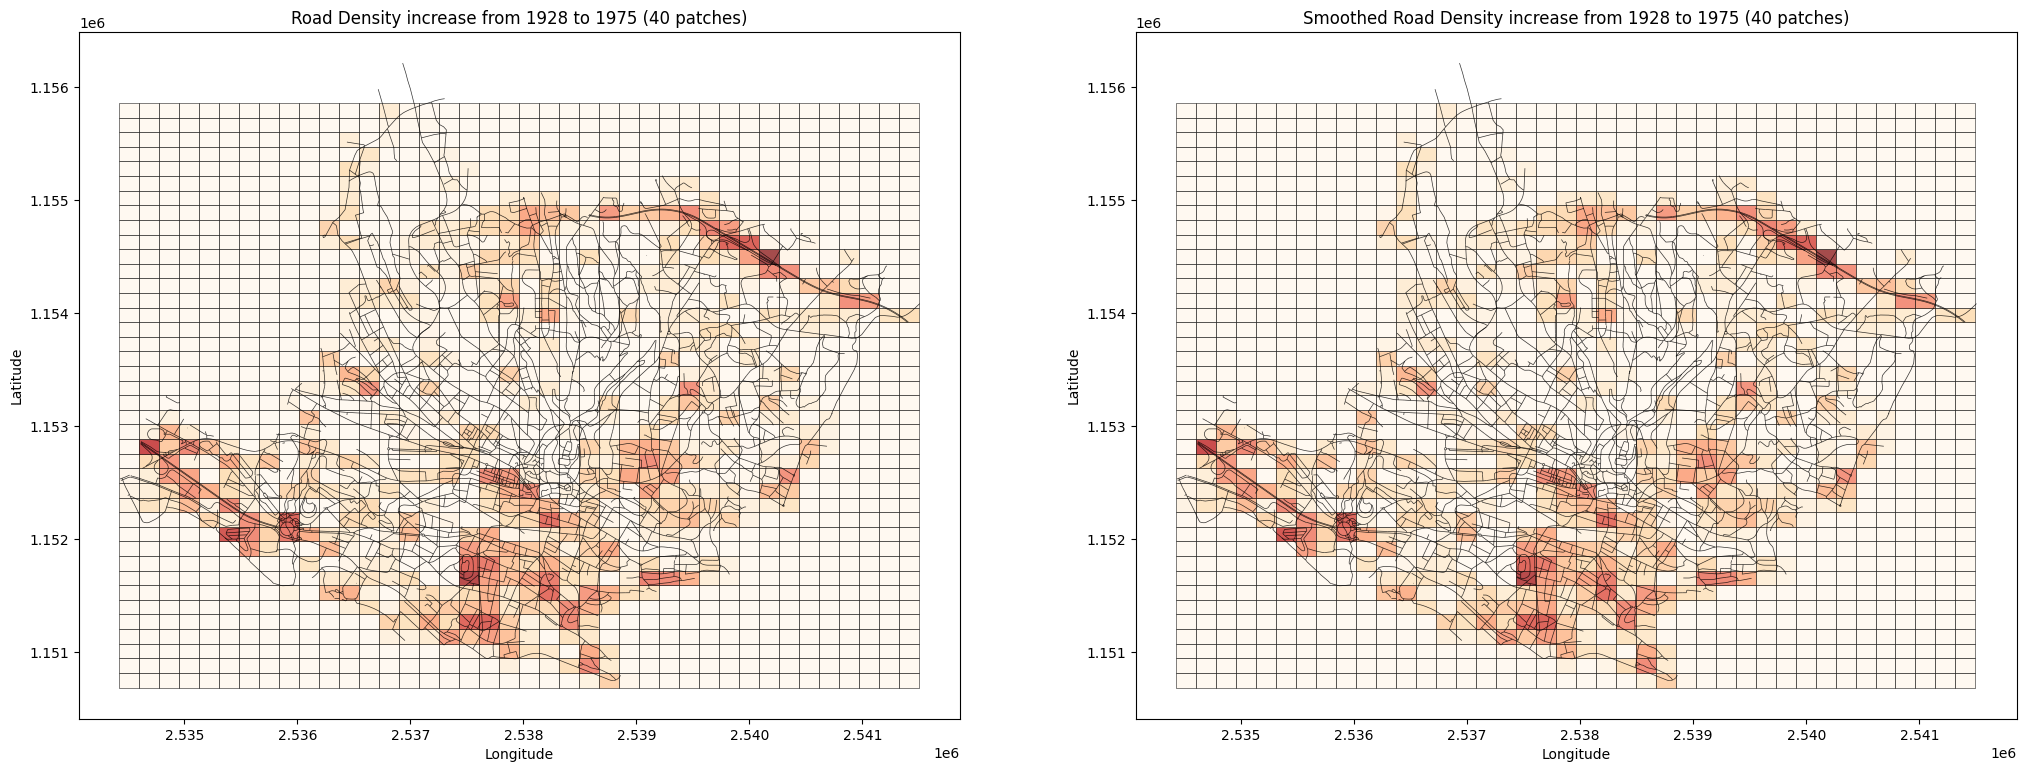

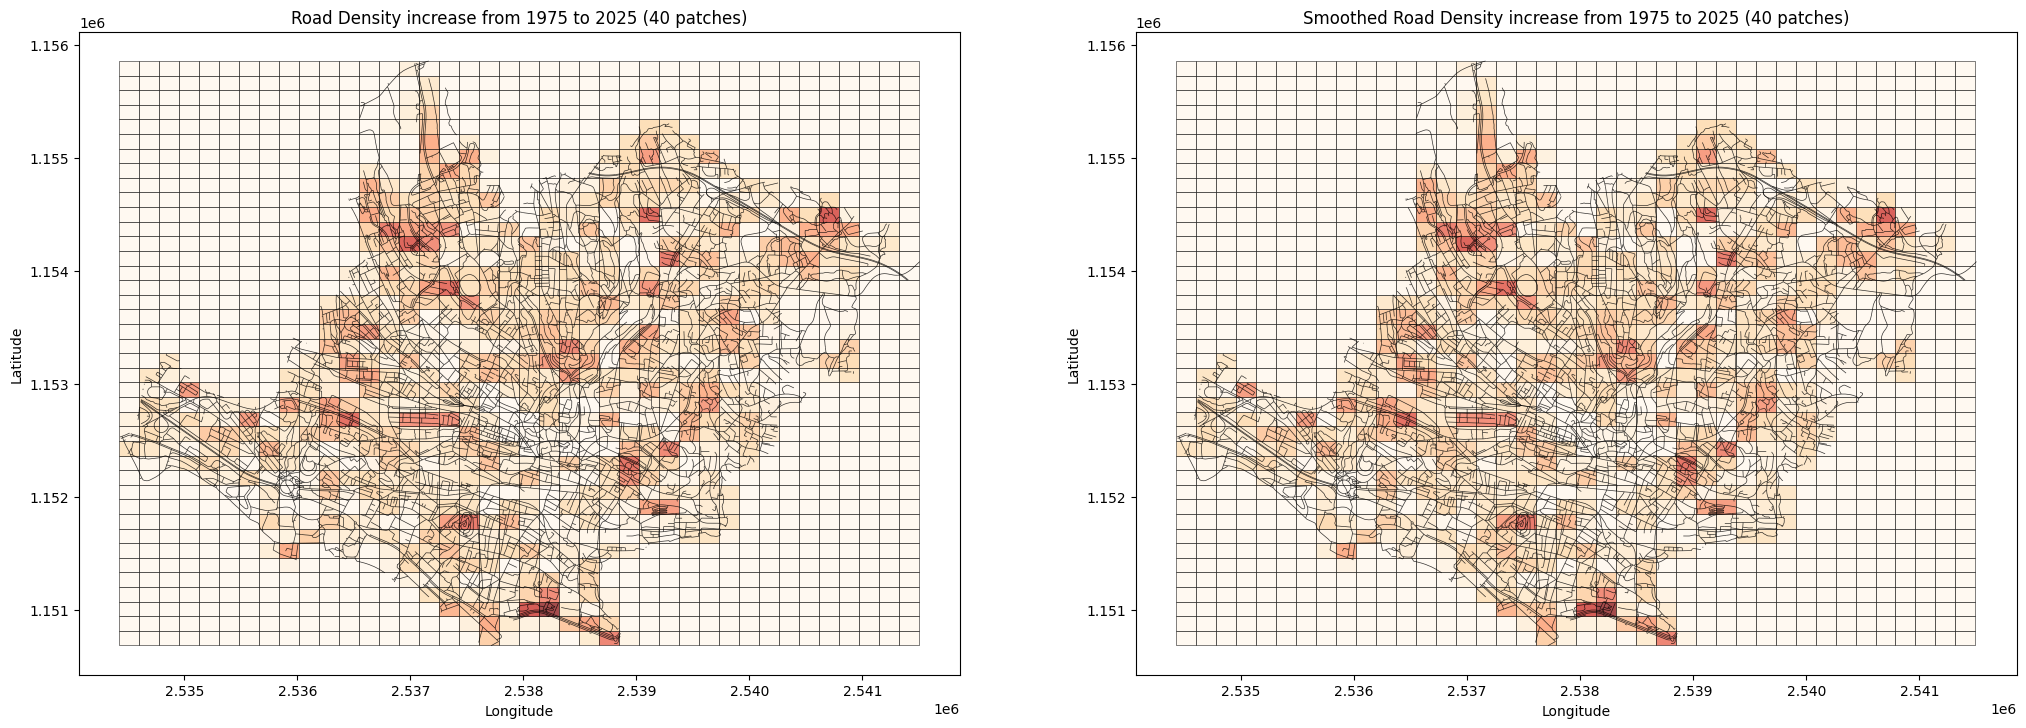

In [39]:
for i in range(len(years)-1):

    fig, axs = plt.subplots(1,2,figsize=(25, 10))

    year = years[i]
    next_year = years[i+1]

    vmin = 0
    vmax = gdf_comparison[f"{year}_to_{next_year}"].max()

    gdf_comparison.plot(column=f"{year}_to_{next_year}", cmap="OrRd", linewidth=0.5, edgecolor="black", alpha=0.7, legend=False, ax=axs[0], vmin=vmin, vmax=vmax)
    gdfs[i+1].plot(color="black", linewidth=0.5, alpha=0.8, ax=axs[0])
    axs[0].set_xlabel("Longitude")
    axs[0].set_ylabel("Latitude")
    axs[0].set_title(f"Road Density increase from {year} to {next_year} ({N_PATCHES} patches)")

    gdf_comparison.plot(column=f"{year}_to_{next_year}_smoothed_value", cmap="OrRd", linewidth=0.5, edgecolor="black", alpha=0.7, legend=False, ax=axs[1], vmin=vmin, vmax=vmax)
    gdfs[i+1].plot(color="black", linewidth=0.5, alpha=0.8, ax=axs[1])
    axs[1].set_xlabel("Longitude")
    axs[1].set_ylabel("Latitude")
    axs[1].set_title(f"Smoothed Road Density increase from {year} to {next_year} ({N_PATCHES} patches)")

    plt.show()

In [22]:
roads_1975_path = "data/processed/roads_1975_wgs84.geojson"
roads_1975_gdf = gpd.read_file(roads_1975_path)

roads_2025_path = "data/processed/roads_2025_wgs84.geojson"
roads_2025_gdf = gpd.read_file(roads_2025_path)

density_incr_1928_1975_path = "data/outputs/density_incr_1928_to_1975_wgs84_n20.geojson"
gdf_density_incr_1928_1975 = gpd.read_file(density_incr_1928_1975_path)

In [5]:
density_incr_1928_1975_path = "data/outputs/density_1975_wgs84.geojson"
gdf_density_incr_1928_1975 = gpd.read_file(density_incr_1928_1975_path)

In [6]:
gdf_density_incr_1928_1975["road_density_length"].describe()

count    6400.000000
mean        0.007820
std         0.011293
min         0.000000
25%         0.000000
50%         0.000000
75%         0.014558
max         0.075839
Name: road_density_length, dtype: float64

In [9]:
gdf_density_incr_1928_1975["1875_to_1928"].describe()

count    6400.000000
mean        0.001654
std         0.008185
min        -0.049563
25%         0.000000
50%         0.000000
75%         0.000505
max         0.057273
Name: 1875_to_1928, dtype: float64

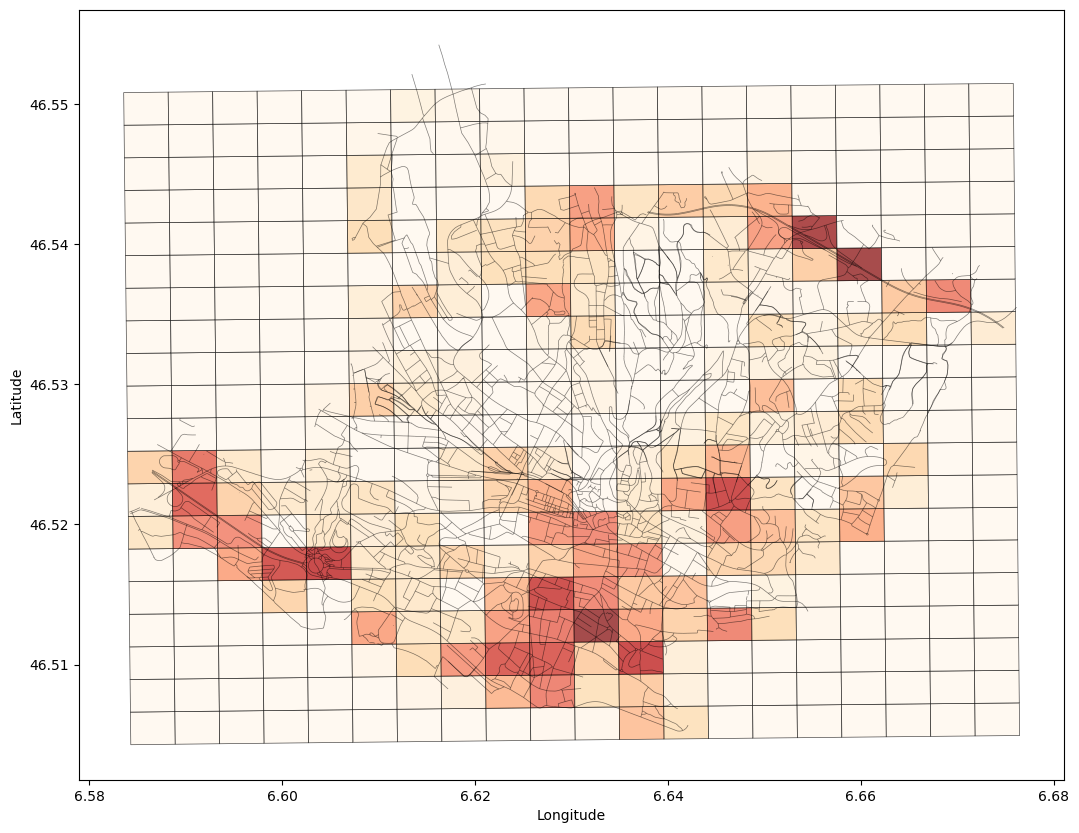

In [23]:
vmin = 0
vmax = gdf_density_incr_1928_1975["1928_to_1975"].max()

fig, ax = plt.subplots(1,1,figsize=(15, 10))
gdf_density_incr_1928_1975.plot(column="1928_to_1975", cmap="OrRd", linewidth=0.5, edgecolor="black", alpha=0.7, legend=False, ax=ax,vmin=vmin,vmax=vmax)
roads_1975_gdf.plot(color="black", linewidth=0.5, alpha=0.5, ax=ax)
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
#density_gdf.plot(column="road_density_area", cmap="OrRd", linewidth=0.5, edgecolor="black", alpha=0.7, legend=False, ax=ax[1])
#roads_gdf.plot(color="black", linewidth=0.5, alpha=0.5, ax=ax[1])
#ax[1].set_title(f"Road Area Density Map {str(year)}")
plt.show()

Zones:
- Axe Ouchy-Lausanne Gare (Ficelle, train à crémaillère)

# Vidy:

Entre 1928 et 1975, la zone de Vidy, à Lausanne, a connu une transformation urbaine majeure, passant d’un espace relativement périphérique à un pôle structurant de la ville, à la fois culturel, sportif et institutionnel.

Le premier jalon de cette évolution remonte à l’inauguration du Stade de Vidy en 1923, aujourd’hui connu sous le nom de Stade Juan Antonio Samaranch. À cette époque, le site n'était encore qu'un terrain en bord de lac, mais il marquait déjà la volonté de la ville de développer le secteur autour du sport et des loisirs.

C’est véritablement à l’approche de l’Exposition nationale suisse de 1964 (Expo64) que Vidy devient un chantier stratégique. Dans le cadre des grands travaux d’infrastructure, la ville de Lausanne entreprend d'importantes modifications. Le remblaiement du bord du lac permet de gagner environ 200 hectares sur le lac Léman, transformant le rivage naturel en esplanades, parcs et zones accessibles au public. Le cours du Flon est en partie comblé, remplacé par des espaces verts et des jardins, marquant une volonté d’intégration paysagère et de renaturation partielle. L’aménagement du rond-point de la Maladière et la construction de l’autoroute A1 entre Genève et Lausanne, dont une portion traverse Vidy, intègrent définitivement le secteur dans la trame de circulation régionale.

Dans le cadre de l'Expo64 elle-même, plusieurs infrastructures culturelles et ludiques voient le jour. Le Théâtre de Vidy, œuvre de l’architecte Max Bill, devient un symbole de modernité et demeure encore aujourd’hui un haut lieu de la création théâtrale. À proximité, la Vallée de la Jeunesse est aménagée pour offrir des espaces de jeux et de découverte aux enfants, tandis que l’Esplanade des Cantons accueille des pavillons représentant les différentes régions suisses, dans un esprit de cohésion nationale.

À la suite de l’Exposition, la municipalité poursuit la transformation du secteur à travers un plan d’aménagement nommé "Zone Verte de Vidy", adopté en 1966. Ce projet vise à pérenniser les acquis de l’Expo64 tout en structurant la zone autour de la détente, du sport et de l’environnement. Dans ce cadre, le Centre sportif de Vidy est développé, culminant avec l’inauguration en 1977 du Stade Pierre de Coubertin. Ce stade original réutilise ingénieusement certaines structures de l’Expo64, notamment les anciennes caves à bières converties en vestiaires, symbolisant un recyclage architectural innovant.

Enfin, un événement de portée internationale vient ancrer définitivement Vidy sur la carte du monde sportif : en 1968, le Comité International Olympique (CIO) installe son siège dans le Château de Vidy, une élégante bâtisse au bord du lac. Ce choix renforce l’identité sportive du quartier et marque le début d’une longue présence du mouvement olympique à Lausanne, désormais surnommée "capitale olympique".


ROND POINT DE LA MALADIÈRE

# Croisette:

Le développement du secteur des Croisettes ainsi que la construction de l’autoroute A9 au nord-est de Lausanne entre les années 1950 et 1975 s’inscrivent dans une phase d’urbanisation rapide du bassin lausannois, marquée par l’essor démographique, la modernisation des infrastructures et l’extension des zones urbaines vers la périphérie.

Le secteur des Croisettes, situé à l’extrémité nord-est de Lausanne, dans la commune d'Épalinges, s’est développé principalement dans les années 1960 et 1970, dans le cadre de la croissance suburbaine lausannoise: 703 habitants en 1943 à 4710 n 1976 à Epalinges. Jusque-là composé de zones agricoles et de hameaux épars, le secteur est ciblé pour un développement résidentiel et fonctionnel, favorisé par la volonté de décentraliser une partie de la population lausannoise vers des zones moins denses, tout en les maintenant connectées au centre.

Ce développement s’accompagne de la construction de logements collectifs, d’équipements scolaires, de commerces de proximité, et d’un tissu urbain structuré. Dès les années 1970, les réflexions sur un système de transport en commun performant pour la région lausannoise intègrent le besoin de desservir ces nouveaux quartiers. Le Plan directeur de la région lausannoise de 1973 évoque un axe structurant nord-sud, préfigurant le futur métro M2, même si la réalisation concrète, et la station des Croisettes, ne verront le jour qu’en 2008.

Ce quartier devient ainsi une porte d’entrée de Lausanne depuis le nord, offrant un mélange de densité urbaine contrôlée, de cadre naturel (à la lisière de la forêt du Jorat) et de fonctions urbaines modernes.

Parallèlement, les autorités fédérales et cantonales planifient dans les années 1960 la construction de l'autoroute A9, destinée à relier Lausanne à Sion, puis à Brigue et l’Italie via le Valais. L’autoroute est pensée comme un axe est-ouest alpin majeur, complémentaire de l’A1 Genève–Zurich et permettant notamment de désengorger l'axe Lausanne-Villeneuve.

Le contournement nord-est de Lausanne, entamé dans les années 1970, s’insère dans ce projet et a un impact direct sur la région des Croisettes et d’Épalinges. Ce tronçon vise à soulager le centre-ville du trafic de transit, tout en améliorant l’accès aux quartiers périphériques et aux communes voisines (Savigny, Belmont, etc.).

L’autoroute A9 est construite dans un environnement topographiquement complexe, nécessitant de nombreux viaducs, tranchées couvertes et ouvrages d’art pour s’insérer dans le paysage sans trop l’altérer. Elle constitue un marqueur fort du paysage urbain et un levier pour le développement de quartiers comme les Croisettes, en assurant une meilleure accessibilité routière et en renforçant l’attractivité résidentielle et commerciale de ces zones.

# Ouchy - Lausanne:

Entre 1928 et 1975, l’axe reliant Ouchy au centre-ville de Lausanne via la gare CFF connaît une intensification continue de son urbanisation. Cette dynamique est fortement soutenue par la présence du chemin de fer Lausanne–Ouchy, affectueusement surnommé la Ficelle, qui structure cet itinéraire en forte pente.

Ce surnom provient du funiculaire d’origine, mis en service en 1877, qui reliait le bord du lac au centre-ville en suivant une pente particulièrement raide, grâce à un système de câble. Mais c’est bien à partir de la modernisation de la ligne en 1958, avec l’introduction de rames à crémaillère, que cette infrastructure devient un véritable levier du développement urbain de l’axe. Plus rapide, plus fiable, ce nouveau métro léger répond mieux aux besoins croissants de mobilité d’une ville en expansion.

Tout au long de ce tracé, entre Ouchy, la gare CFF et le Flon, les transformations sont significatives. À Ouchy, les décennies d’après-guerre voient la construction de nouveaux immeubles résidentiels et administratifs, souvent de gabarits importants, qui remplacent progressivement les bâtiments plus anciens ou les terrains encore vacants. Ce développement répond à la pression foncière croissante et à la volonté d’optimiser un secteur devenu particulièrement bien desservi.

Le secteur de la Gare, lui, se densifie fortement dans les années 1950 et 1960. Des bâtiments modernes à usage mixte (commerces, bureaux, logements) apparaissent notamment le long de l’avenue de la Gare, transformant l’entrée de ville en un espace fonctionnel et vivant. Cette zone devient un pôle multimodal, articulant les réseaux ferroviaires nationaux et le métro urbain.

Au Flon, bien que la vocation industrielle et logistique reste dominante jusqu’à la fin des années 1970, la station centrale de la Ficelle contribue déjà à renforcer son rôle de carrefour. Si la transformation du quartier interviendra plus tard, les prémices d’une revalorisation apparaissent dès cette période à travers des réflexions sur l’aménagement du centre-ville.

In [44]:
gdf_comparison[["geometry","1875_to_1928"]]

geometry  1875_to_1928
0     POLYGON ((2534599.303 1150687.894, 2534599.303...           0.0
1     POLYGON ((2534599.303 1150817.193, 2534599.303...           0.0
2     POLYGON ((2534599.303 1150946.491, 2534599.303...           0.0
3     POLYGON ((2534599.303 1151075.79, 2534599.303 ...           0.0
4     POLYGON ((2534599.303 1151205.089, 2534599.303...           0.0
...                                                 ...           ...
1595  POLYGON ((2541497.298 1155213.35, 2541497.298 ...           0.0
1596  POLYGON ((2541497.298 1155342.649, 2541497.298...           0.0
1597  POLYGON ((2541497.298 1155471.948, 2541497.298...           0.0
1598  POLYGON ((2541497.298 1155601.247, 2541497.298...           0.0
1599  POLYGON ((2541497.298 1155730.545, 2541497.298...           0.0

[1600 rows x 2 columns]

In [26]:
density_2025_gdf.to_crs('EPSG:4326').to_file("data/outputs/density_2025_wgs84_n30.geojson")
density_1975_gdf.to_crs('EPSG:4326').to_file("data/outputs/density_1975_wgs84_n30.geojson")
density_1928_gdf.to_crs('EPSG:4326').to_file("data/outputs/density_1928_wgs84_n30.geojson")
density_1875_gdf.to_crs('EPSG:4326').to_file("data/outputs/density_1875_wgs84_n30.geojson")

gdf_comparison[["geometry","1875_to_1928"]].to_crs('EPSG:4326').to_file("data/outputs/density_incr_1875_to_1928_wgs84_n30.geojson")
gdf_comparison[["geometry","1928_to_1975"]].to_crs('EPSG:4326').to_file("data/outputs/density_incr_1928_to_1975_wgs84_n30.geojson")
gdf_comparison[["geometry","1975_to_2025"]].to_crs('EPSG:4326').to_file("data/outputs/density_incr_1975_to_2025_wgs84_n30.geojson")

In [163]:
gdf_comparison['minx'] = gdf_comparison.bounds['minx']
gdf_comparison['maxx'] = gdf_comparison.bounds['maxx']
gdf_comparison['miny'] = gdf_comparison.bounds['miny']
gdf_comparison['maxy'] = gdf_comparison.bounds['maxy']

In [164]:
gdf_comparison['width'] = gdf_comparison['maxx'] - gdf_comparison['minx']   # Δx
gdf_comparison['length'] = gdf_comparison['maxy'] - gdf_comparison['miny']

In [165]:
gdf_comparison.crs

<Projected CRS: EPSG:2056>
Name: CH1903+ / LV95
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Liechtenstein; Switzerland.
- bounds: (5.96, 45.82, 10.49, 47.81)
Coordinate Operation:
- name: Swiss Oblique Mercator 1995
- method: Hotine Oblique Mercator (variant B)
Datum: CH1903+
- Ellipsoid: Bessel 1841
- Prime Meridian: Greenwich

In [166]:
gdf_comparison[["width","length"]]

width     length
0     88.44283  69.060557
1     88.44283  69.060557
2     88.44283  69.060557
3     88.44283  69.060557
4     88.44283  69.060557
...        ...        ...
6395  88.44283  69.060557
6396  88.44283  69.060557
6397  88.44283  69.060557
6398  88.44283  69.060557
6399  88.44283  69.060557

[6400 rows x 2 columns]

In [167]:
#gdf_comparison.to_crs(epsg=4326).to_file("density_increase_1975_2025_80.geojson",driver="GeoJSON")

Analyser nom des rues et regroupements des noms des rues (chemins, routes, ...)

- Analyse géographiques de la typologie des routes
- Essayer un rapprochement géographiques entre les rues de 2025 et les anciennes (la rue la plus proche à moins de 5m)

In [8]:
roads_2025_gdf.loc[0]

OBJECTID                                                   587433
DKM_UUID                   {6EED44D4-5CC8-4702-99AB-D87E80597EFB}
OBJEKTART                                                  2m_Weg
NAME                                                         None
NAME_LANG                                                    None
ROUTEN_NR                                                    None
INVERT                                                       None
SG                                                          Klein
STUFE                                                           0
KUNSTBAUTE                                                  Keine
BEFAHRBAR                                                    Wahr
BELAGSART                                               Hartbelag
EROEFFNUNG                              1901-01-01 00:00:00+00:00
IM_BAU                                                  ungueltig
KREISEL                                                    Falsch
KREISEL_DM

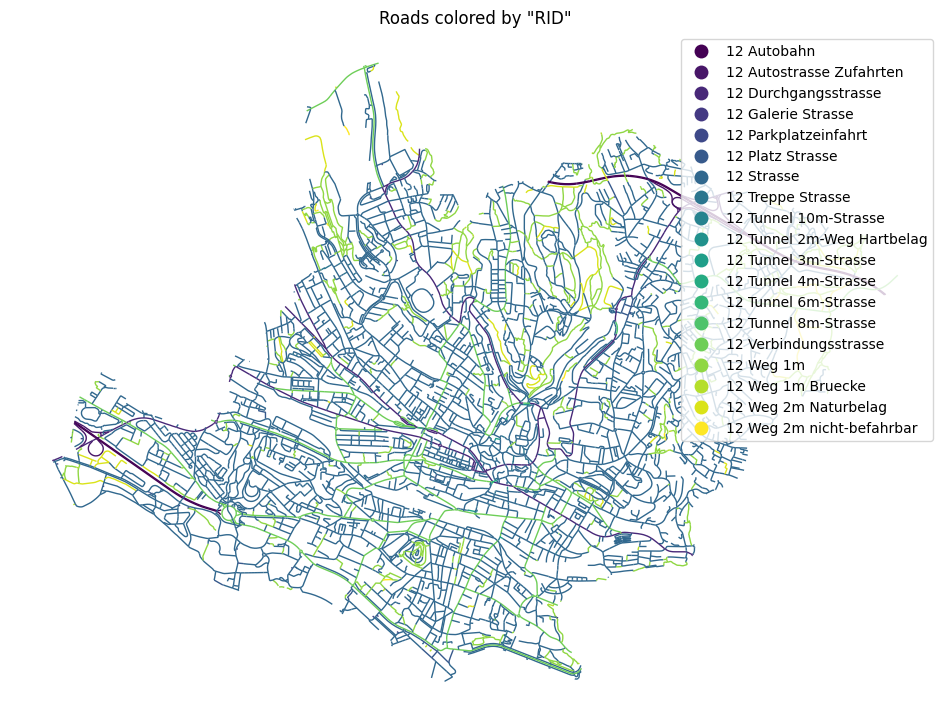

In [10]:
column = 'RID'

gdf_to_plot = roads_2025_gdf[roads_2025_gdf[column].notnull()]

# Plotting
fig, ax = plt.subplots(figsize=(12, 10))

gdf_to_plot.plot(ax=ax, column=column, cmap='viridis', linewidth=1, legend=True)

ax.set_title(f'Roads colored by "{column}"')
ax.set_axis_off()

plt.show()

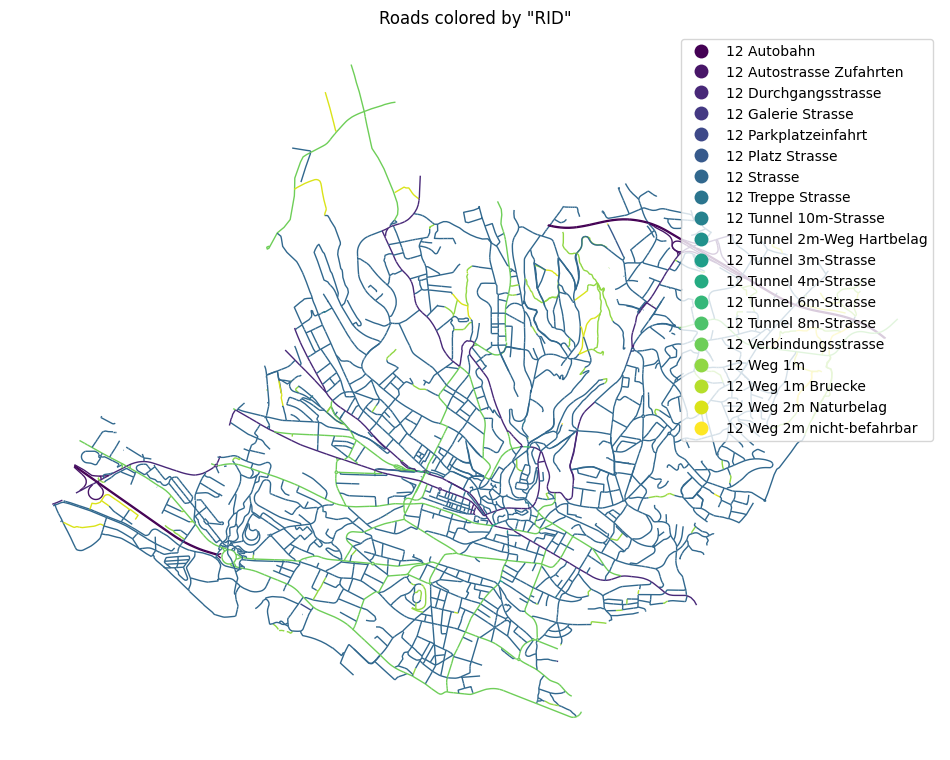

In [11]:
column = 'RID'

gdf_to_plot = roads_1975_gdf[roads_1975_gdf[column].notnull()]

# Plotting
fig, ax = plt.subplots(figsize=(12, 10))

gdf_to_plot.plot(ax=ax, column=column, cmap='viridis', linewidth=1, legend=True)

ax.set_title(f'Roads colored by "{column}"')
ax.set_axis_off()

plt.show()

Markdown méthodo:
- Faire les cartes 1975 et 2025
- Carte de 0 pour les autres
- Cartes de base: SuisseTopo
- Méthodo densité
- Comparer à histoire lausanoise